### set folder_name and day session to analyze

In [220]:
name = 'ANM1'
session = '20240203_d5'

### imports

In [221]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [222]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (70, 7)
MTXTrialType shape: (1000, 5)
number of trials: 70


In [223]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANM1/LeverData_ANM1_20240203_d5.mat' mode='r' encoding='UTF-8'>

For mac:

In [224]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/: File exists


For windows:

In [225]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/: File exists


preview trials

In [226]:
respMTX.shape

(70, 7)

In [227]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 1:2]-respMTX[0:respMTX_shape-1, 1:2], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[17.848358 0.000000]
 [25.088178 1.000000]
 [23.082779 2.000000]
 [21.861836 3.000000]
 [22.941799 4.000000]
 [24.781838 5.000000]
 [22.260589 6.000000]
 [20.837363 7.000000]
 [15.000792 8.000000]
 [24.861979 9.000000]
 [22.064380 10.000000]
 [17.514243 11.000000]
 [18.871865 12.000000]
 [21.780927 13.000000]
 [16.467210 14.000000]
 [15.289554 15.000000]
 [17.801402 16.000000]
 [23.936419 17.000000]
 [20.729628 18.000000]
 [21.514938 19.000000]
 [19.607506 20.000000]
 [17.248652 21.000000]
 [20.706188 22.000000]
 [19.709880 23.000000]
 [13.460303 24.000000]
 [14.752114 25.000000]
 [15.211467 26.000000]
 [13.811062 27.000000]
 [14.832553 28.000000]
 [16.783481 29.000000]
 [14.543672 30.000000]
 [22.874554 31.000000]
 [12.385320 32.000000]
 [21.529148 33.000000]
 [13.447072 34.000000]
 [14.844424 35.000000]
 [15.343325 36.000000]
 [18.596900 37.000000]
 [16.595626 38.000000]
 [24.368556 39.000000]
 [23.871608 40.000000]
 [12.046431 41.000000]
 [18.481285 42.000000]
 [13.796319 43.000000

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [228]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 65351

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 8167194
vector saved to .bin file ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/full.bin
finished a trialITI: 170174 index:0 trialITI length: 104823 samples = ~17s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/trial0.bin
finished a trialITI: 317507 index:1 trialITI length: 147333 samples = ~25s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/trial1.bin
finished a trialITI: 453065 index:2 trialITI length: 135558 samples = ~23s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/trial2.bin
finished a trialITI: 581451 index:3 trialITI length: 128386 samples = ~21s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM1/PreprocessLeverData_ANM1_20240203_d5/trial3.bin
finished a tria

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [229]:
num_trials = 64

### Look at sampling rates for the `lever_data`

In [230]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  17.848357800000002
Number of leverdata samples:  104823
Estimated freq:  5872.977288700476
Trial  1
Duration in MATLAB seconds from respMTX:  25.0881784
Number of leverdata samples:  147333
Estimated freq:  5872.606518136047
Trial  2
Duration in MATLAB seconds from respMTX:  23.082779000000002
Number of leverdata samples:  135558
Estimated freq:  5872.689765820657
Trial  3
Duration in MATLAB seconds from respMTX:  21.861835900000003
Number of leverdata samples:  128386
Estimated freq:  5872.608347590789
Trial  4
Duration in MATLAB seconds from respMTX:  22.94179899999999
Number of leverdata samples:  134730
Estimated freq:  5872.686793219663
Trial  5
Duration in MATLAB seconds from respMTX:  24.78183820000001
Number of leverdata samples:  145535
Estimated freq:  5872.647493921574
Trial  6
Duration in MATLAB seconds from respMTX:  22.260589399999986
Number of leverdata samples:  130728
Estimated freq:  5872.620785144174
Trial  7
Duratio

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [231]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [232]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [233]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [234]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

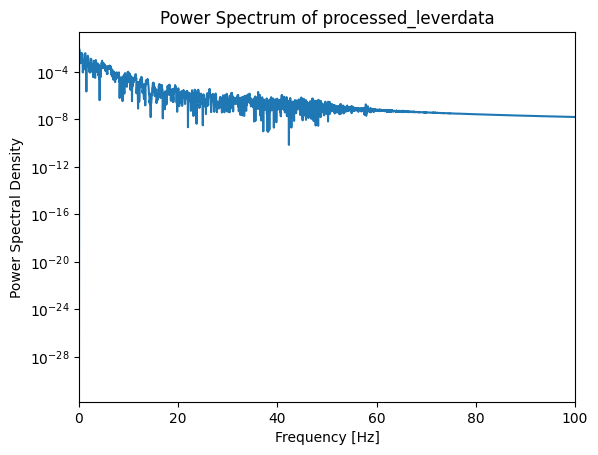

In [235]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)